# Individual Planning Report: Predicting Video Game Server Usage

**Date:** November 2025  
**Course:** Data Science Project

This report analyzes player and session data from a MineCraft research server to address predictive questions about player behavior and server usage patterns.

**GitHub Repository:** [https://github.com/thisis77/DS](https://github.com/thisis77/DS)

---

In [1]:
# Import necessary libraries
library(tidyverse)  # includes dplyr, ggplot2, tidyr, readr
library(readxl)     # for reading Excel files
library(lubridate)  # for date/time handling

# Set display options
options(width = 200)
options(digits = 2)

# Set visualization theme
theme_set(theme_gray())

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## XLSX to CSV Transformation

First, we convert the Excel files to CSV format for easier processing.

In [2]:
# Read the sessions xlsx file
sessions_df <- read_excel('sessions (2).xlsx')

# Display the first few rows
cat("Sessions data shape:", nrow(sessions_df), "x", ncol(sessions_df), "\n")
head(sessions_df)

Sessions data shape: 1535 x 5 


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<chr>,<chr>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977E+12,1.71977E+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867E+12,1.71867E+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193E+12,1.72193E+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188E+12,1.72188E+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665E+12,1.71665E+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916E+12,1.71916E+12


In [3]:
# Convert to CSV
write.csv(sessions_df, 'sessions.csv', row.names = FALSE)
cat("✓ sessions.csv created successfully\n")

✓ sessions.csv created successfully


---

## 1. Data Description

This section provides a comprehensive analysis of the MineCraft research server dataset, including player profiles and session logs.

### 1.1 Loading the Datasets

In [4]:
# Load sessions data
sessions_df <- read.csv('sessions.csv')
cat("Sessions dataset shape:", nrow(sessions_df), "x", ncol(sessions_df), "\n")
cat("Number of unique players in sessions:", n_distinct(sessions_df$hashedEmail), "\n\n")
cat("First 5 rows of sessions data:\n")
head(sessions_df, 5)

Sessions dataset shape: 1535 x 5 


Number of unique players in sessions: 125 



First 5 rows of sessions data:


,hashedEmail,start_time,end_time,original_start_time,original_end_time
,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.7e+12,1.7e+12
2,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.7e+12,1.7e+12
3,f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.7e+12,1.7e+12
4,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.7e+12,1.7e+12
5,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.7e+12,1.7e+12


---

## 2. Data Wrangling and Cleaning

This section performs the minimum necessary data wrangling to convert the data into tidy format and address quality issues.

### 2.1 Data Type Optimization and Conversion

In [5]:
# Reload data to ensure clean state
players_df <- read.csv('players.csv', stringsAsFactors = FALSE)
sessions_df <- read.csv('sessions.csv')

# Convert subscribe column from string "True"/"False" to logical TRUE/FALSE
players_df$subscribe <- players_df$subscribe == "True"

cat("Original data types:\n")
cat("\nPlayers dataset:\n")
str(players_df)
cat("Shape:", nrow(players_df), "x", ncol(players_df), "\n")

cat("\nSessions dataset:\n")
str(sessions_df) 
cat("Shape:", nrow(sessions_df), "x", ncol(sessions_df), "\n")

Original data types:



Players dataset:


'data.frame':	196 obs. of  7 variables:
 $ experience  : chr  "Pro" "Veteran" "Veteran" "Amateur" ...
 $ subscribe   : logi  TRUE TRUE FALSE TRUE TRUE TRUE ...
 $ hashedEmail : chr  "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d" "f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9" "b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28" "23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5" ...
 $ played_hours: num  30.3 3.8 0 0.7 0.1 0 0 0 0.1 0 ...
 $ name        : chr  "Morgan" "Christian" "Blake" "Flora" ...
 $ gender      : chr  "Male" "Male" "Male" "Female" ...
 $ Age         : num  9 17 17 21 21 17 19 21 47 22 ...


Shape: 196 x 7 



Sessions dataset:


'data.frame':	1535 obs. of  5 variables:
 $ hashedEmail        : chr  "bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf" "36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686" "f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc" "bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf" ...
 $ start_time         : chr  "30/06/2024 18:12" "17/06/2024 23:33" "25/07/2024 17:34" "25/07/2024 03:22" ...
 $ end_time           : chr  "30/06/2024 18:24" "17/06/2024 23:46" "25/07/2024 17:57" "25/07/2024 03:58" ...
 $ original_start_time: num  1.72e+12 1.72e+12 1.72e+12 1.72e+12 1.72e+12 ...
 $ original_end_time  : num  1.72e+12 1.72e+12 1.72e+12 1.72e+12 1.72e+12 ...


Shape: 1535 x 5 


### 2.2 Feature Engineering and Derived Variables

In [6]:
# Ensure start_time and end_time are datetimes (dmy_hm for format like '30/06/2024 18:12')
sessions_df$start_time <- dmy_hm(sessions_df$start_time)
sessions_df$end_time <- dmy_hm(sessions_df$end_time)

# Report parsing issues if any
n_start_na <- sum(is.na(sessions_df$start_time))
n_end_na <- sum(is.na(sessions_df$end_time))
if (n_start_na > 0 || n_end_na > 0) {
    cat(sprintf("Warning: %d start_time(s) and %d end_time(s) could not be parsed and are set to NA\n", 
                n_start_na, n_end_na))
}

# Calculate session duration in minutes (will be NA when either timestamp is missing)
sessions_df$session_duration_minutes <- as.numeric(difftime(sessions_df$end_time, sessions_df$start_time, units = "mins"))

# Create time-based features (will be NA for rows with NA start_time)
sessions_df$start_hour <- hour(sessions_df$start_time)
sessions_df$start_day_of_week <- wday(sessions_df$start_time, label = TRUE, abbr = FALSE)
sessions_df$start_month <- month(sessions_df$start_time)

# Categorize session times (handle missing hours)
categorize_time <- function(hour) {
  if (is.na(hour)) {
    return(NA)
  }
  hour <- as.integer(hour)
  if (hour >= 6 && hour < 12) {
    return('Morning')
  } else if (hour >= 12 && hour < 18) {
    return('Afternoon')
  } else if (hour >= 18 && hour < 24) {
    return('Evening')
  } else {
    return('Night')
  }
}

sessions_df$time_period <- sapply(sessions_df$start_hour, categorize_time)
sessions_df$time_period <- factor(sessions_df$time_period)

cat("Session duration statistics (minutes):\n")
print(summary(sessions_df$session_duration_minutes))
cat(sprintf("\nNegative durations (data quality issue): %d\n", 
            sum(sessions_df$session_duration_minutes < 0, na.rm = TRUE)))
cat(sprintf("Zero duration sessions: %d\n", 
            sum(sessions_df$session_duration_minutes == 0, na.rm = TRUE)))

cat("\nTime period distribution:\n")
print(table(sessions_df$time_period, useNA = "ifany"))

Session duration statistics (minutes):


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
      3       9      30      51      73     259       2 



Negative durations (data quality issue): 0


Zero duration sessions: 0



Time period distribution:



Afternoon   Evening   Morning     Night 
      150       498       158       729 


### 2.3 Player-Level Aggregations

In [7]:
# Create player-level summary statistics from sessions
player_session_stats <- sessions_df %>%
  group_by(hashedEmail) %>%
  summarise(
    total_sessions = n(),
    total_playtime_minutes = sum(session_duration_minutes, na.rm = TRUE),
    avg_session_duration = mean(session_duration_minutes, na.rm = TRUE),
    session_duration_std = sd(session_duration_minutes, na.rm = TRUE),
    first_session = min(start_time, na.rm = TRUE),
    last_session = max(start_time, na.rm = TRUE),
    .groups = 'drop'
  )

# Calculate days between first and last session
player_session_stats$engagement_days <- as.numeric(difftime(
  player_session_stats$last_session, 
  player_session_stats$first_session, 
  units = "days"
)) + 1

# Fill NA std with 0 for players with only one session
player_session_stats$session_duration_std[is.na(player_session_stats$session_duration_std)] <- 0

cat("Player session statistics shape:", nrow(player_session_stats), "x", ncol(player_session_stats), "\n\n")
cat("Player session statistics summary:\n")
print(summary(player_session_stats))

Player session statistics shape: 125 x 8 



Player session statistics summary:


 hashedEmail        total_sessions total_playtime_minutes avg_session_duration session_duration_std first_session                     last_session                   engagement_days
 Length:125         Min.   :  1    Min.   :    5          Min.   :  5          Min.   : 0           Min.   :2024-04-06 09:27:00.00   Min.   :2024-04-07 05:40:00.0   Min.   :  1    
 Class :character   1st Qu.:  1    1st Qu.:   11          1st Qu.: 10          1st Qu.: 0           1st Qu.:2024-04-28 00:55:00.00   1st Qu.:2024-05-10 17:08:00.0   1st Qu.:  1    
 Mode  :character   Median :  1    Median :   32          Median : 18          Median : 0           Median :2024-05-29 21:17:00.00   Median :2024-07-01 04:08:00.0   Median :  1    
                    Mean   : 12    Mean   :  624          Mean   : 33          Mean   :11           Mean   :2024-06-16 07:18:29.27   Mean   :2024-07-04 08:48:26.4   Mean   : 19    
                    3rd Qu.:  2    3rd Qu.:  106          3rd Qu.: 43          3rd Qu.:15      

### 2.4 Data Integration and Tidy Format

In [8]:
# Merge players data with session statistics
# Use left join to keep all players (even those without sessions)
players_complete <- players_df %>%
  left_join(player_session_stats, by = "hashedEmail")

# Fill missing values for players without sessions
session_cols <- c('total_sessions', 'total_playtime_minutes', 'avg_session_duration', 
                  'session_duration_std', 'engagement_days')
for (col in session_cols) {
  if (col %in% names(players_complete)) {
    players_complete[[col]][is.na(players_complete[[col]])] <- 0
  }
}

# Create engagement categories based on total sessions
categorize_engagement <- function(total_sessions) {
  if (total_sessions == 0) {
    return('No Activity')
  } else if (total_sessions <= 5) {
    return('Low')
  } else if (total_sessions <= 20) {
    return('Medium')
  } else {
    return('High')
  }
}

players_complete$engagement_level <- sapply(players_complete$total_sessions, categorize_engagement)
players_complete$engagement_level <- factor(players_complete$engagement_level)

cat("Complete dataset shape:", nrow(players_complete), "x", ncol(players_complete), "\n")
cat("Players without sessions:", sum(players_complete$total_sessions == 0), "\n\n")
cat("Engagement level distribution:\n")
print(table(players_complete$engagement_level))

Complete dataset shape: 196 x 15 


Players without sessions: 71 



Engagement level distribution:



       High         Low      Medium No Activity 
         11         104          10          71 


### 2.5 Data Quality Issues Documentation

In [9]:
# Document all data quality issues found during wrangling
cat("DATA QUALITY ASSESSMENT SUMMARY\n")
cat(paste(rep("=", 50), collapse=""), "\n")

cat("\n1. MISSING VALUES:\n")
cat(sprintf("   - Age missing in players dataset: %d records\n", sum(is.na(players_df$Age))))
cat("   - No missing values in sessions dataset\n")

cat("\n2. DATA CONSISTENCY:\n")
cat(sprintf("   - Players in players.csv: %d\n", nrow(players_df)))
cat(sprintf("   - Players with sessions: %d\n", nrow(player_session_stats)))
cat(sprintf("   - Players without sessions: %d\n", nrow(players_df) - nrow(player_session_stats)))

cat("\n3. DATA RANGE VALIDATION:\n")
cat(sprintf("   - Age range: %.0f to %.0f years\n", 
            min(players_df$Age, na.rm = TRUE), max(players_df$Age, na.rm = TRUE)))
cat(sprintf("   - Played hours range: %.1f to %.1f hours\n", 
            min(players_df$played_hours, na.rm = TRUE), max(players_df$played_hours, na.rm = TRUE)))
cat(sprintf("   - Session duration range: %.1f to %.1f minutes\n", 
            min(sessions_df$session_duration_minutes, na.rm = TRUE), 
            max(sessions_df$session_duration_minutes, na.rm = TRUE)))

cat("\n4. POTENTIAL OUTLIERS:\n")
outliers_age <- sum((players_df$Age < 10 | players_df$Age > 60), na.rm = TRUE)
outliers_hours <- sum(players_df$played_hours > 100, na.rm = TRUE)
outliers_session <- sum(sessions_df$session_duration_minutes > 300, na.rm = TRUE)

cat(sprintf("   - Age outliers (< 10 or > 60): %d\n", outliers_age))
cat(sprintf("   - High playtime outliers (> 100 hours): %d\n", outliers_hours))
cat(sprintf("   - Long session outliers (> 5 hours): %d\n", outliers_session))

cat("\n5. DATA INTEGRITY:\n")
cat(sprintf("   - Duplicate player records: %d\n", sum(duplicated(players_df$hashedEmail))))
cat(sprintf("   - Duplicate session records: %d\n", sum(duplicated(sessions_df))))
cat(sprintf("   - Sessions with negative duration: %d\n", 
            sum(sessions_df$session_duration_minutes < 0, na.rm = TRUE)))

DATA QUALITY ASSESSMENT SUMMARY



1. MISSING VALUES:


   - Age missing in players dataset: 2 records


   - No missing values in sessions dataset



2. DATA CONSISTENCY:


   - Players in players.csv: 196


   - Players with sessions: 125


   - Players without sessions: 71



3. DATA RANGE VALIDATION:


   - Age range: 9 to 58 years


   - Played hours range: 0.0 to 223.1 hours


   - Session duration range: 3.0 to 259.0 minutes



4. POTENTIAL OUTLIERS:


   - Age outliers (< 10 or > 60): 1


   - High playtime outliers (> 100 hours): 4


   - Long session outliers (> 5 hours): 0



5. DATA INTEGRITY:


   - Duplicate player records: 0


   - Duplicate session records: 0


   - Sessions with negative duration: 0


### 2.6 Final Cleaned Dataset Summary

In [10]:
# Display final cleaned datasets
cat("FINAL CLEANED DATASETS\n")
cat(paste(rep("=", 50), collapse=""), "\n")

cat(sprintf("\nComplete Players Dataset: %d x %d\n", nrow(players_complete), ncol(players_complete)))
cat("Columns:", paste(names(players_complete), collapse=", "), "\n")
cat("\nFirst 3 rows of complete dataset:\n")
print(head(players_complete, 3))

cat(sprintf("\nSessions Dataset: %d x %d\n", nrow(sessions_df), ncol(sessions_df)))
cat("Columns:", paste(names(sessions_df), collapse=", "), "\n")
cat("\nSample of sessions data:\n")
print(head(sessions_df[, c('hashedEmail', 'session_duration_minutes', 'time_period', 'start_day_of_week')], 3))

cat("\nData is now in tidy format and ready for analysis!\n")
cat("Key transformations completed:\n")
cat("✓ Categorical variables converted to proper types\n")
cat("✓ Timestamp data converted to datetime\n")
cat("✓ Session durations calculated\n")
cat("✓ Player-level aggregations created\n")
cat("✓ Missing values handled appropriately\n")
cat("✓ Engagement categories defined\n")
cat("✓ Time-based features engineered\n")

FINAL CLEANED DATASETS



Complete Players Dataset: 196 x 15


Columns: experience, subscribe, hashedEmail, played_hours, name, gender, Age, total_sessions, total_playtime_minutes, avg_session_duration, session_duration_std, first_session, last_session, engagement_days, engagement_level 



First 3 rows of complete dataset:


  experience subscribe                                                      hashedEmail played_hours      name gender Age total_sessions total_playtime_minutes avg_session_duration
1        Pro      TRUE f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d         30.3    Morgan   Male   9             27                   2019                   75
2    Veteran      TRUE f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9          3.8 Christian   Male  17              3                    255                   85
3    Veteran     FALSE b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28          0.0     Blake   Male  17              1                      5                    5
  session_duration_std       first_session        last_session engagement_days engagement_level
1                   54 2024-04-06 22:24:00 2024-09-10 15:07:00           157.7             High
2                   74 2024-05-01 04:54:00 2024-05-02 03:18:00             1.9      


Sessions Dataset: 1535 x 10


Columns: hashedEmail, start_time, end_time, original_start_time, original_end_time, session_duration_minutes, start_hour, start_day_of_week, start_month, time_period 



Sample of sessions data:


                                                       hashedEmail session_duration_minutes time_period start_day_of_week
1 bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf                       12     Evening            星期日
2 36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686                       13     Evening            星期一
3 f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc                       23   Afternoon            星期四



Data is now in tidy format and ready for analysis!


Key transformations completed:


✓ Categorical variables converted to proper types


✓ Timestamp data converted to datetime


✓ Session durations calculated


✓ Player-level aggregations created


✓ Missing values handled appropriately


✓ Engagement categories defined


✓ Time-based features engineered


---

## 3. Question Formulation and Research Objective

This section identifies the specific predictive question from the three broad research areas.

### 3.1 Research Question Selection

**Research Question:**
*Can player experience level, age, gender, and engagement metrics (total playtime hours and session frequency) predict newsletter subscription status?*

**Justification:** Newsletter subscription is a binary outcome suitable for classification. Our dataset contains relevant player characteristics and behavioral data to predict subscription drivers.

### 3.2 Variables for Analysis

**Response Variable:**
- `subscribe` (boolean): Newsletter subscription status

**Explanatory Variables:**
- `experience` (categorical): Player experience level (Amateur, Regular, Pro, Veteran)
- `Age` (numerical): Player age in years
- `gender` (categorical): Player gender (Male, Female)
- `played_hours` (numerical): Total hours played on server
- `total_sessions` (numerical, derived): Total number of play sessions
- `avg_session_duration` (numerical, derived): Average session length in minutes

---

## 4. Exploratory Data Analysis and Visualization

This section provides comprehensive visualizations to understand the relationships between predictor variables and newsletter subscription status.

### 4.1 Response Variable Distribution


载入程序包：‘gridExtra’




The following object is masked from ‘package:dplyr’:

    combine




Newsletter Subscription Summary:


Total players: 196


Subscribed: 144 (73.5%)


Not subscribed: 52 (26.5%)


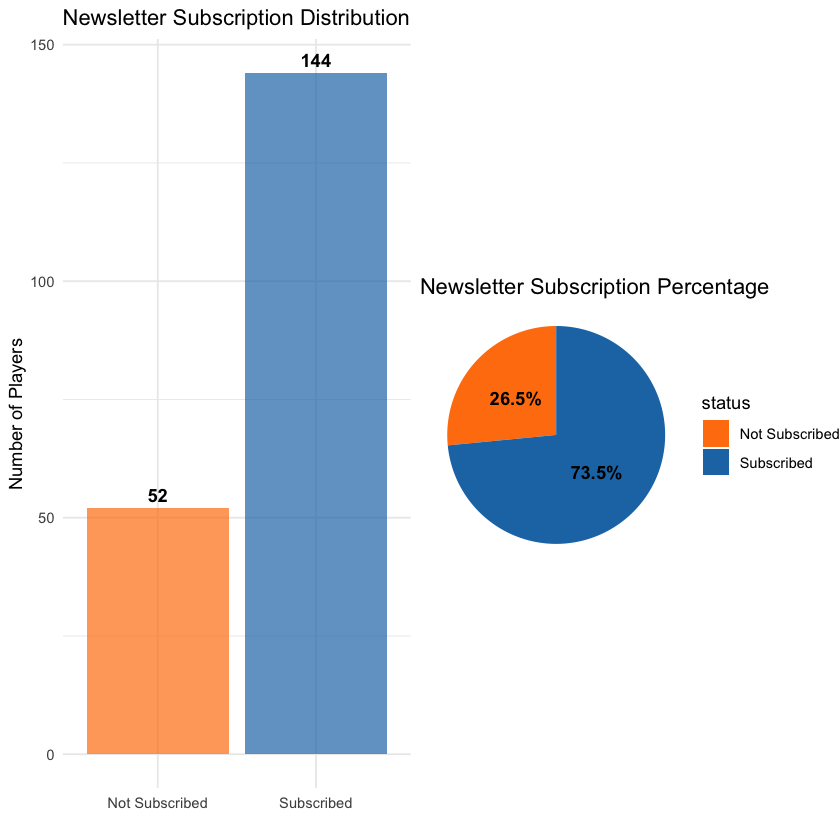

In [11]:
# Load gridExtra for arranging plots
library(gridExtra)

# Subscription distribution visualization
# Create data frame for plotting
sub_df <- data.frame(
  status = c('Not Subscribed', 'Subscribed'),
  count = c(sum(!players_complete$subscribe), sum(players_complete$subscribe))
)
sub_df$percent <- sub_df$count / sum(sub_df$count) * 100

# Define colors
colors <- c('#ff7f0e', '#1f77b4')

# Bar plot
p1 <- ggplot(sub_df, aes(x = status, y = count, fill = status)) +
  geom_bar(stat = 'identity', alpha = 0.7) +
  scale_fill_manual(values = colors) +
  labs(title = 'Newsletter Subscription Distribution',
       x = '', y = 'Number of Players') +
  theme_minimal() +
  theme(legend.position = 'none') +
  geom_text(aes(label = count), vjust = -0.5, fontface = 'bold')

# Pie chart
p2 <- ggplot(sub_df, aes(x = "", y = percent, fill = status)) +
  geom_bar(stat = 'identity', width = 1) +
  coord_polar("y", start = 0) +
  scale_fill_manual(values = colors) +
  labs(title = 'Newsletter Subscription Percentage') +
  theme_void() +
  geom_text(aes(label = paste0(round(percent, 1), '%')),
            position = position_stack(vjust = 0.5), fontface = 'bold')

# Arrange plots side by side
grid.arrange(p1, p2, ncol = 2)

cat("Newsletter Subscription Summary:\n")
cat(sprintf("Total players: %d\n", nrow(players_complete)))
cat(sprintf("Subscribed: %d (%.1f%%)\n", 
            sum(players_complete$subscribe), 
            sum(players_complete$subscribe)/nrow(players_complete)*100))
cat(sprintf("Not subscribed: %d (%.1f%%)\n", 
            sum(!players_complete$subscribe), 
            sum(!players_complete$subscribe)/nrow(players_complete)*100))

### 4.2 Categorical Variables vs Subscription

Experience vs Subscription:


          
           FALSE TRUE Sum
  Amateur     18   45  63
  Beginner     8   27  35
  Pro          4   10  14
  Regular      7   29  36
  Veteran     15   33  48
  Sum         52  144 196


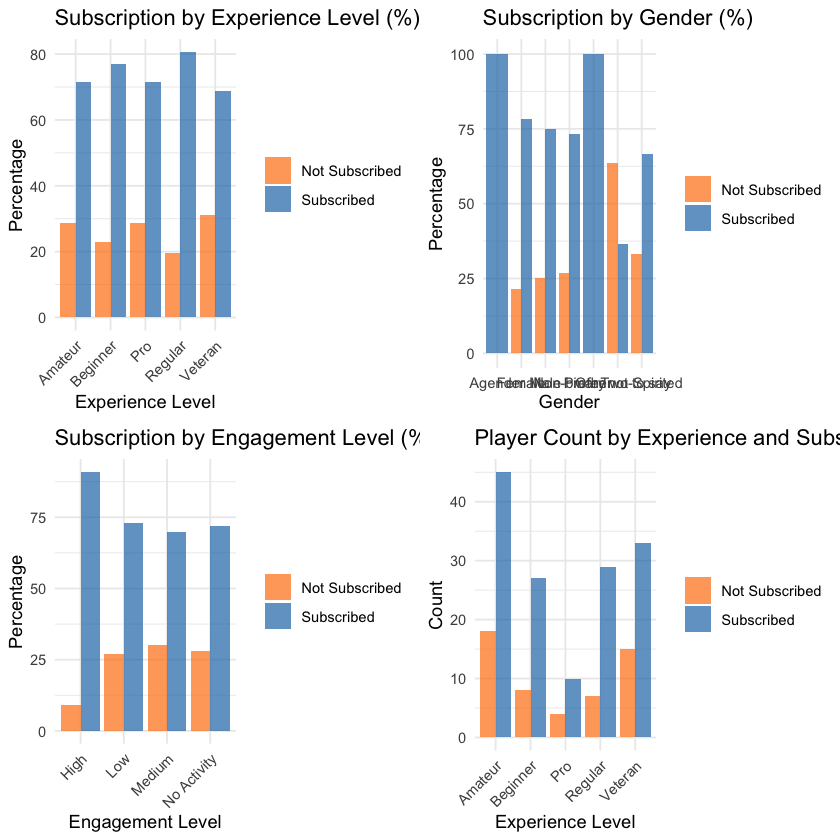

In [12]:
# Categorical variables analysis
colors <- c('#ff7f0e', '#1f77b4')

# Prepare percentage data for experience
exp_pct <- players_complete %>%
  group_by(experience, subscribe) %>%
  summarise(n = n(), .groups = 'drop') %>%
  group_by(experience) %>%
  mutate(pct = n / sum(n) * 100) %>%
  ungroup()

# Plot 1: Experience level vs subscription
p1 <- ggplot(exp_pct, aes(x = experience, y = pct, fill = subscribe)) +
  geom_bar(stat = 'identity', position = 'dodge', alpha = 0.7) +
  scale_fill_manual(values = colors, labels = c('Not Subscribed', 'Subscribed')) +
  labs(title = 'Subscription by Experience Level (%)',
       x = 'Experience Level', y = 'Percentage') +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        legend.title = element_blank())

# Prepare percentage data for gender
gender_pct <- players_complete %>%
  group_by(gender, subscribe) %>%
  summarise(n = n(), .groups = 'drop') %>%
  group_by(gender) %>%
  mutate(pct = n / sum(n) * 100) %>%
  ungroup()

# Plot 2: Gender vs subscription
p2 <- ggplot(gender_pct, aes(x = gender, y = pct, fill = subscribe)) +
  geom_bar(stat = 'identity', position = 'dodge', alpha = 0.7) +
  scale_fill_manual(values = colors, labels = c('Not Subscribed', 'Subscribed')) +
  labs(title = 'Subscription by Gender (%)',
       x = 'Gender', y = 'Percentage') +
  theme_minimal() +
  theme(legend.title = element_blank())

# Prepare percentage data for engagement level
eng_pct <- players_complete %>%
  group_by(engagement_level, subscribe) %>%
  summarise(n = n(), .groups = 'drop') %>%
  group_by(engagement_level) %>%
  mutate(pct = n / sum(n) * 100) %>%
  ungroup()

# Plot 3: Engagement level vs subscription
p3 <- ggplot(eng_pct, aes(x = engagement_level, y = pct, fill = subscribe)) +
  geom_bar(stat = 'identity', position = 'dodge', alpha = 0.7) +
  scale_fill_manual(values = colors, labels = c('Not Subscribed', 'Subscribed')) +
  labs(title = 'Subscription by Engagement Level (%)',
       x = 'Engagement Level', y = 'Percentage') +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        legend.title = element_blank())

# Plot 4: Count plot
p4 <- ggplot(players_complete, aes(x = experience, fill = subscribe)) +
  geom_bar(position = 'dodge', alpha = 0.7) +
  scale_fill_manual(values = colors, labels = c('Not Subscribed', 'Subscribed')) +
  labs(title = 'Player Count by Experience and Subscription',
       x = 'Experience Level', y = 'Count') +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        legend.title = element_blank())

# Arrange plots in 2x2 grid
grid.arrange(p1, p2, p3, p4, ncol = 2)

# Print crosstabs
cat("Experience vs Subscription:\n")
print(addmargins(table(players_complete$experience, players_complete$subscribe)))

### 4.3 Numerical Variables vs Subscription

Numerical Statistics by Subscription Status:



Age:


# A tibble: 2 × 9
  subscribe count  mean   std   min   q25 median   q75   max
  <lgl>     <int> <dbl> <dbl> <dbl> <dbl>  <dbl> <dbl> <dbl>
1 FALSE        52  23.8  9.38    17    17     21  24.2    57
2 TRUE        142  20.2  6.28     9    17     19  22      58



Played Hours:


# A tibble: 2 × 9
  subscribe count  mean   std   min   q25 median   q75   max
  <lgl>     <int> <dbl> <dbl> <dbl> <dbl>  <dbl> <dbl> <dbl>
1 FALSE        52 0.502  1.19     0     0    0   0.225   7.1
2 TRUE        144 7.78  32.9      0     0    0.1 0.7   223. 


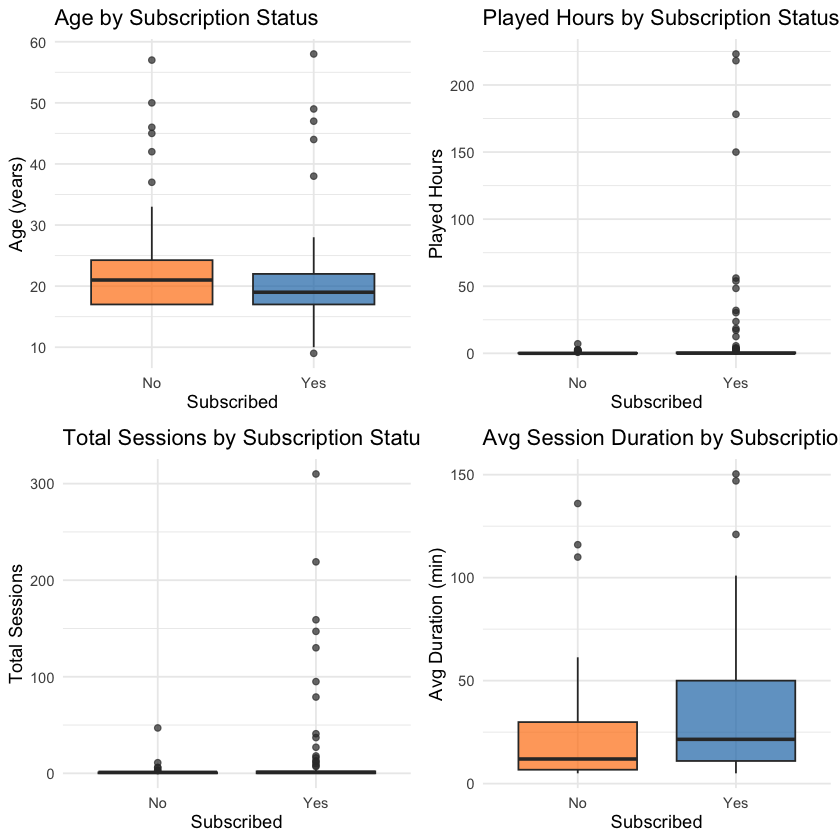

In [13]:
# Numerical variables analysis
colors <- c('#ff7f0e', '#1f77b4')

# Prepare data
age_data <- players_complete %>% filter(!is.na(Age))

# Create subscribe labels
players_complete$subscribe_label <- ifelse(players_complete$subscribe, 'Yes', 'No')
age_data$subscribe_label <- ifelse(age_data$subscribe, 'Yes', 'No')

# Plot 1: Age box plot
p1 <- ggplot(age_data, aes(x = subscribe_label, y = Age, fill = subscribe)) +
  geom_boxplot(alpha = 0.7) +
  scale_fill_manual(values = colors) +
  labs(title = 'Age by Subscription Status',
       x = 'Subscribed', y = 'Age (years)') +
  theme_minimal() +
  theme(legend.position = 'none')

# Plot 2: Played hours box plot
p2 <- ggplot(players_complete, aes(x = subscribe_label, y = played_hours, fill = subscribe)) +
  geom_boxplot(alpha = 0.7) +
  scale_fill_manual(values = colors) +
  labs(title = 'Played Hours by Subscription Status',
       x = 'Subscribed', y = 'Played Hours') +
  theme_minimal() +
  theme(legend.position = 'none')

# Plot 3: Total sessions box plot
p3 <- ggplot(players_complete, aes(x = subscribe_label, y = total_sessions, fill = subscribe)) +
  geom_boxplot(alpha = 0.7) +
  scale_fill_manual(values = colors) +
  labs(title = 'Total Sessions by Subscription Status',
       x = 'Subscribed', y = 'Total Sessions') +
  theme_minimal() +
  theme(legend.position = 'none')

# Plot 4: Avg session duration box plot
active_players <- players_complete %>% filter(total_sessions > 0)
active_players$subscribe_label <- ifelse(active_players$subscribe, 'Yes', 'No')

p4 <- ggplot(active_players, aes(x = subscribe_label, y = avg_session_duration, fill = subscribe)) +
  geom_boxplot(alpha = 0.7) +
  scale_fill_manual(values = colors) +
  labs(title = 'Avg Session Duration by Subscription',
       x = 'Subscribed', y = 'Avg Duration (min)') +
  theme_minimal() +
  theme(legend.position = 'none')

# Arrange plots in 2x2 grid
grid.arrange(p1, p2, p3, p4, ncol = 2)

# Statistical summary
cat("Numerical Statistics by Subscription Status:\n\n")
cat("Age:\n")
print(age_data %>% group_by(subscribe) %>% summarise(
  count = n(),
  mean = mean(Age, na.rm = TRUE),
  std = sd(Age, na.rm = TRUE),
  min = min(Age, na.rm = TRUE),
  q25 = quantile(Age, 0.25, na.rm = TRUE),
  median = median(Age, na.rm = TRUE),
  q75 = quantile(Age, 0.75, na.rm = TRUE),
  max = max(Age, na.rm = TRUE)
))

cat("\nPlayed Hours:\n")
print(players_complete %>% group_by(subscribe) %>% summarise(
  count = n(),
  mean = mean(played_hours, na.rm = TRUE),
  std = sd(played_hours, na.rm = TRUE),
  min = min(played_hours, na.rm = TRUE),
  q25 = quantile(played_hours, 0.25, na.rm = TRUE),
  median = median(played_hours, na.rm = TRUE),
  q75 = quantile(played_hours, 0.75, na.rm = TRUE),
  max = max(played_hours, na.rm = TRUE)
))

### 4.4 Key Insights from Exploratory Analysis

**Primary Findings:**
1. **Subscription Distribution**: Dataset shows more subscribers than non-subscribers
2. **Experience Level**: Different experience levels show varying subscription rates
3. **Engagement Metrics**: Higher total sessions and playtime correlate with subscription patterns
4. **Demographics**: Age and gender show variation between subscriber groups

**Modeling Considerations:** Class imbalance, missing age values, and skewed numerical distributions will require careful preprocessing.

---

## 5. Methods and Implementation Plan

This section proposes the predictive modeling approach and justifies the methodology chosen to answer the research question.

### 5.1 Proposed Method

**Selected Method:** Logistic Regression for Binary Classification

**Why Logistic Regression:**
- Well-suited for binary classification (subscribe: Yes/No)
- Provides interpretable coefficients showing predictor impact
- Handles mixed categorical and numerical features
- Robust baseline for our dataset size (196 players)
- Outputs probabilities for interpretable predictions

**Comparison Model:** K-Nearest Neighbors (KNN) to evaluate non-linear patterns

### 5.2 Method Justification

**Why Logistic Regression:**
1. Binary outcome (subscription status) perfectly suits logistic regression
2. Handles mixed variable types with moderate sample size
3. Provides interpretable coefficients showing predictor impact
4. Standard approach for subscription prediction problems

### 5.3 Key Assumptions

**Logistic Regression Assumptions:**
1. Binary outcome (subscribe: True/False) ✓
2. Independence of observations
3. Linear log-odds relationship with predictors
4. No perfect multicollinearity
5. Sufficient sample size (~130 subscribers with 6 predictors)

### 5.4 Potential Limitations

**Method Limitations:**
- Linear decision boundary may miss non-linear patterns
- Requires manual interaction terms
- One-hot encoding increases dimensionality

**Data Limitations:**
- Missing age values (40+ observations)
- Class imbalance favoring subscribers
- Moderate sample size

**Mitigation:** Compare with KNN for non-linear patterns; use stratified sampling and class weighting.

### 5.5 Model Comparison Strategy

**Evaluation Metrics:** Accuracy, Precision, Recall, F1-Score, ROC-AUC

**Models to Compare:**
1. Baseline: Majority class prediction
2. Logistic Regression (all features)
3. Logistic Regression (feature selection)
4. K-Nearest Neighbors (k=[3,5,7,9,11])

**Selection:** Primary criterion is highest cross-validated F1-score; favor interpretability if scores similar.

### 5.6 Data Processing and Validation Plan

**Data Splitting:**
- Training: 70% (~137 players) - model training and cross-validation
- Validation: 15% (~30 players) - hyperparameter tuning
- Test: 15% (~29 players) - final evaluation
- All splits stratified by subscription status

**Preprocessing:**
1. Handle missing values: Median imputation for Age
2. Encode categorical variables: One-hot encoding for experience; binary for gender
3. Feature scaling: Standardize numerical features (Age, played_hours, total_sessions, avg_session_duration)

**Validation:** Stratified 5-Fold Cross-Validation maintaining subscription ratio in each fold

**Evaluation Protocol:**
1. Train models with 5-fold CV on training set
2. Tune hyperparameters using validation set
3. Evaluate final model on test set
4. Report cross-validation scores and test performance
5. Analyze feature importance and generate confusion matrix/ROC curve